In [1]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

In [28]:
def augment(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)
    
    return transform

In [29]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(10, 10), squeeze=True)
        f.set_tight_layout(h_pad=5, w_pad=5)

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 12), squeeze=True)
        plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=0.01)

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

In [30]:
image = cv2.imread(r"C:/Users/User/Documents/Research Projects/3 car parking/new_data/training/image_2/000007_10.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(r"C:/Users/User/Documents/Research Projects/3 car parking/new_data/training/semantic_rgb/000007_10.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

transform = augment(1920, 1280)
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

cv2.imwrite('./image.png',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('./mask.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

visualize(transformed_image, transformed_mask, image, mask)


ValueError: Requested crop size (1280, 1920) is larger than the image size (375, 1242)

In [55]:
!mkdir aug_images
!mkdir aug_masks

In [56]:
images_dir = 'C:/Users/User/Documents/Research Projects/3 car parking/data/train_images/train/'
masks_dir = 'C:/Users/User/Documents/Research Projects/3 car parking/data/train_masks/train/'

In [57]:
file_names = np.sort(os.listdir(images_dir)) 
file_names = np.char.split(file_names, '.')
filenames = np.array([])
for i in range(len(file_names)):
    filenames = np.append(filenames, file_names[i][0])

In [58]:
def augment_dataset(count):
    '''Function for data augmentation
        Input:
            count - total no. of images after augmentation = initial no. of images * count
        Output:
            writes augmented images (input images & segmentation masks) to the working directory
    '''
    transform_1 = augment(512, 512)
    transform_2 = augment(480, 480)
    transform_3 = augment(512, 512)
    transform_4 = augment(800, 800)
    transform_5 = augment(1024, 1024)
    transform_6 = augment(800, 800)
    transform_7 = augment(1600, 1600)
    transform_8 = augment(1920, 1280)
    
    i = 0
    for i in range(count):
        for file in filenames:
            tile = file.split('_')[1]
            img = cv2.imread(images_dir+file+'.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(masks_dir+file+'.png')
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            if tile == 't1':
                transformed = transform_1(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t2':
                transformed = transform_2(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t3':
                transformed = transform_3(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t4':
                transformed = transform_4(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t5':
                transformed = transform_5(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t6':
                transformed = transform_6(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t7':
                transformed = transform_7(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t8':
                transformed = transform_8(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
                
            cv2.imwrite('./aug_images/aug_{}_'.format(str(i+1))+file+'.jpg',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
            cv2.imwrite('./aug_masks/aug_{}_'.format(str(i+1))+file+'.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

In [59]:
augment_dataset(8)

In [4]:
train_images = "C:/Users/User/Documents/Research Projects/3 car parking/step2/new_data/train/images/"
train_masks = "C:/Users/User/Documents/Research Projects/3 car parking/step2/new_data/train/masks/"
val_images = "C:/Users/User/Documents/Research Projects/3 car parking/step2/new_data/valid/images/"
val_masks = "C:/Users/User/Documents/Research Projects/3 car parking/step2/new_data/valid/masks/"

In [3]:
file_names = np.sort(os.listdir(train_images + 'train/')) 
file_names = np.char.split(file_names, '.')
filenames = np.array([])
for i in range(len(file_names)):
    filenames = np.append(filenames, file_names[i][0])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/User/Documents/Research Projects/3 car parking/step2/new_data/train/images/train/'

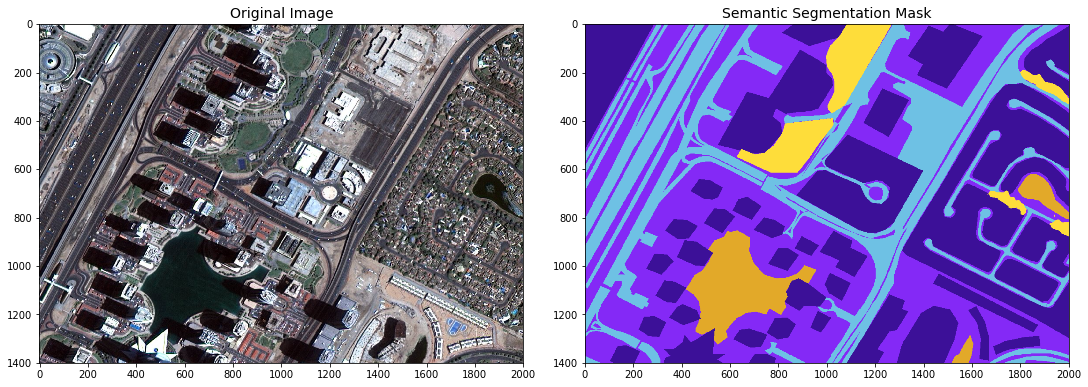

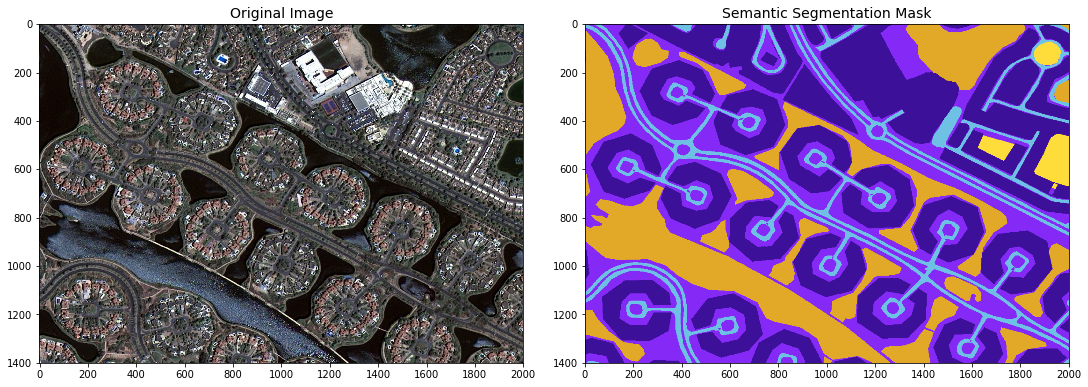

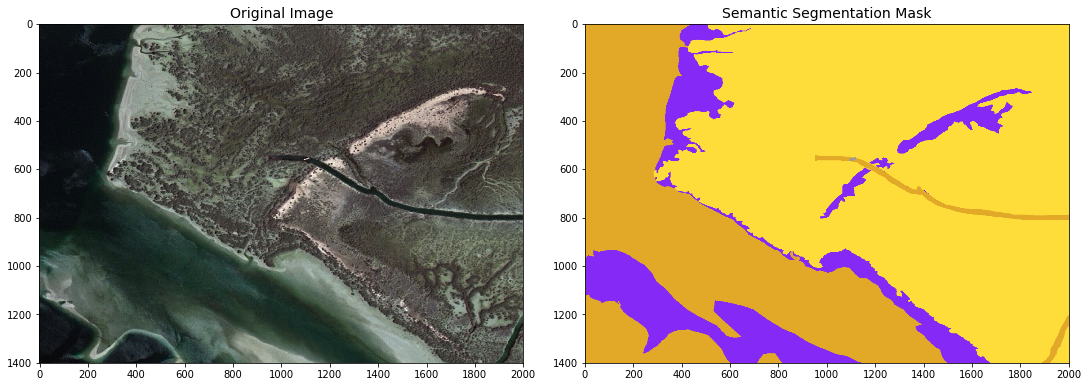

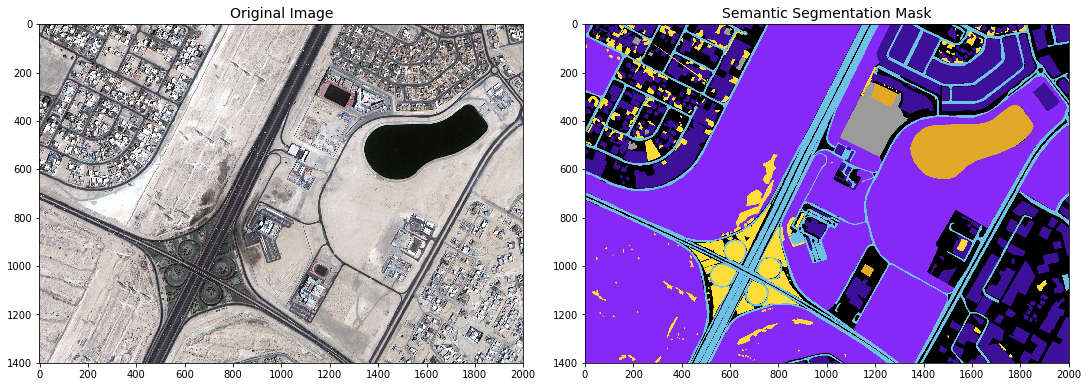

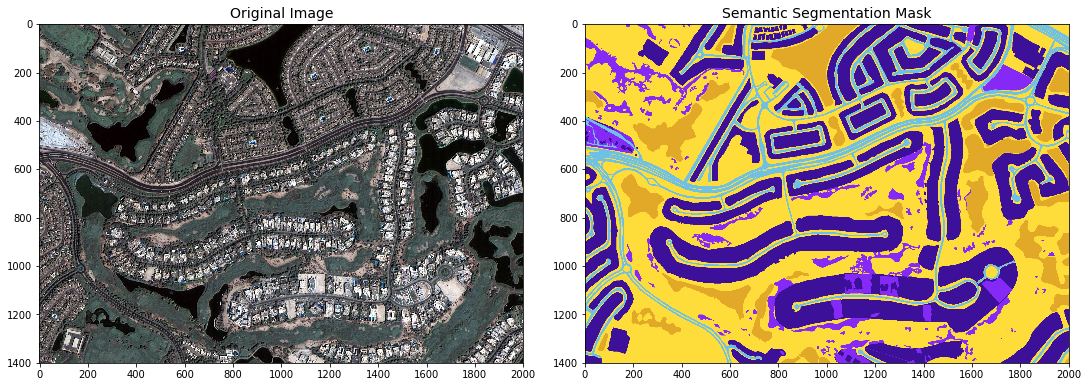

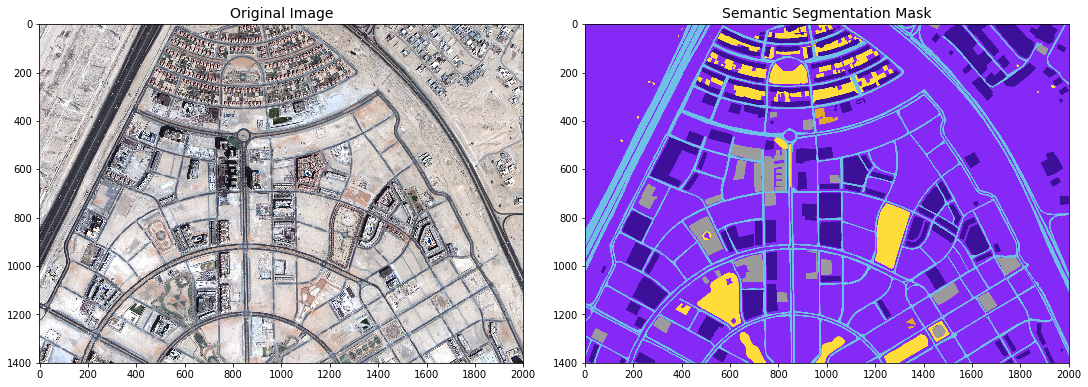

In [4]:
def show_data(files, original_images_dir, label_images_dir):

    for file in files:
        fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
        
        axs[0].imshow(cv2.resize(cv2.imread(original_images_dir+'train/'+str(file)+'.jpg'), (2000,1400)))
        axs[0].set_title('Original Image', fontdict = {'fontsize':14, 'fontweight': 'medium'})
        axs[0].set_xticks(np.arange(0, 2001, 200))
        axs[0].set_yticks(np.arange(0, 1401, 200))
        axs[0].grid(False)
        axs[0].axis(True)

        semantic_label_image = cv2.imread(label_images_dir+ 'train/'+str(file)+'.png')
        semantic_label_image = cv2.cvtColor(semantic_label_image, cv2.COLOR_BGR2RGB)
        semantic_label_image = cv2.resize(semantic_label_image, (2000,1400))
        axs[1].imshow(semantic_label_image)
        axs[1].set_title('Semantic Segmentation Mask', fontdict = {'fontsize':14, 'fontweight': 'medium'})
        axs[1].set_xticks(np.arange(0, 2001, 200))
        axs[1].set_yticks(np.arange(0, 1401, 200))
        axs[1].grid(False)
        axs[1].axis(True)

        plt.savefig('./sample_'+file, facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)
        plt.show()

        
files = ['image_t4_001', 'image_t4_005', 'image_t6_002', 'image_t8_003', 'image_t8_004', 'image_t8_006']    
show_data(files, train_images, train_masks)    

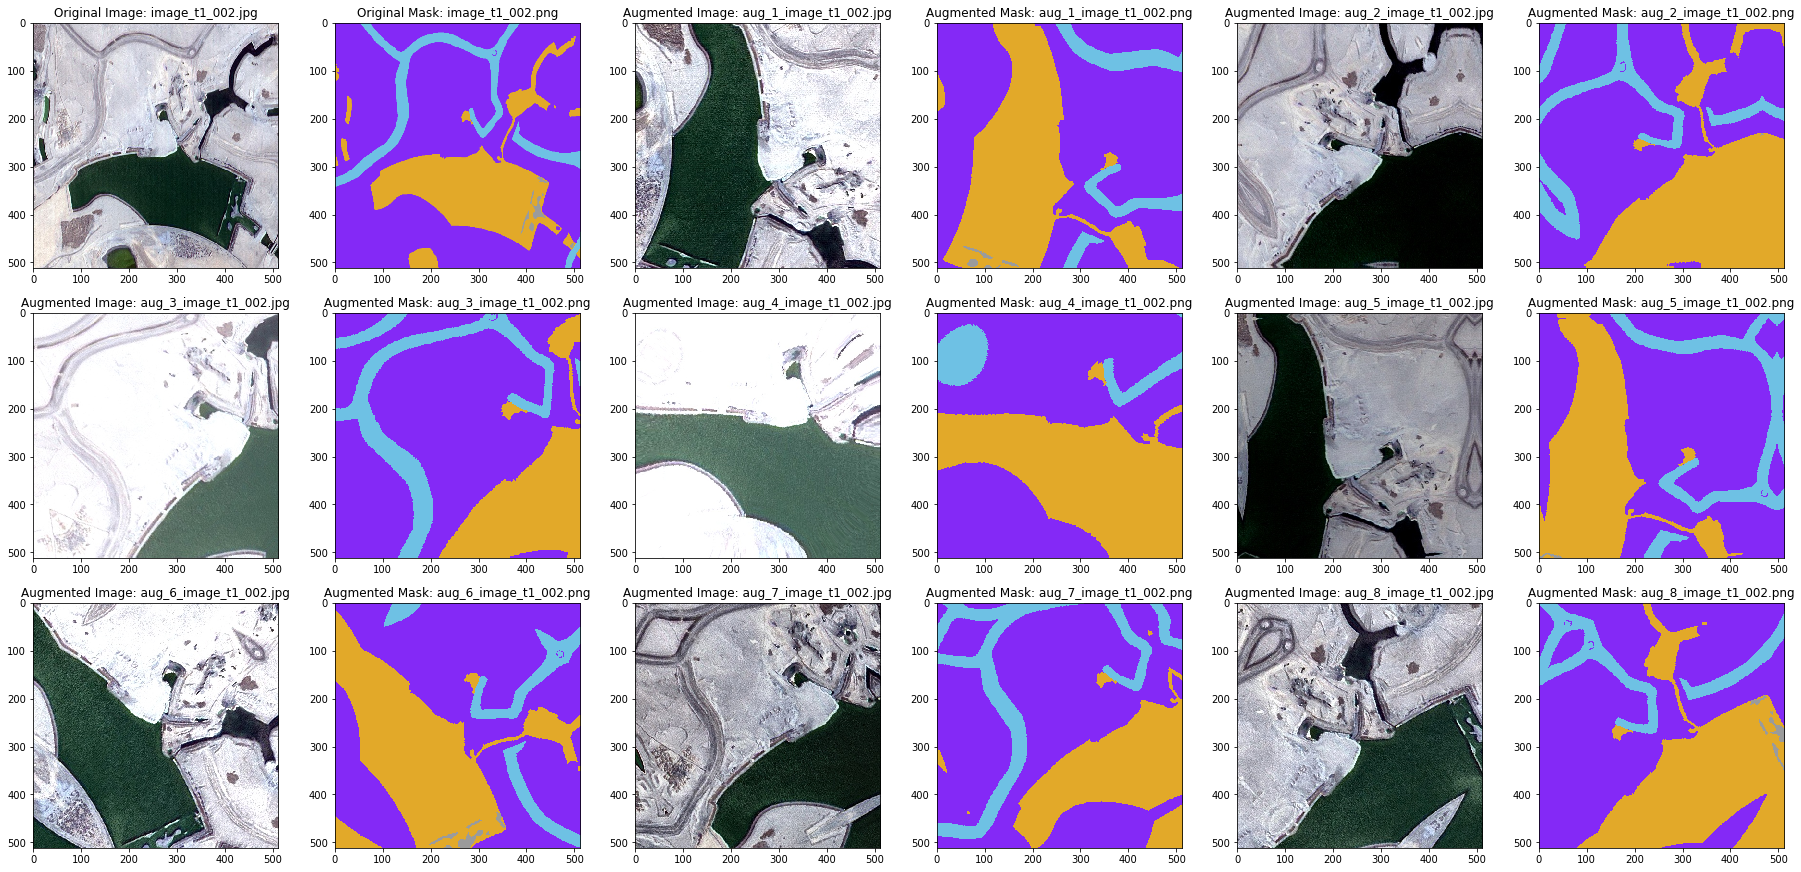

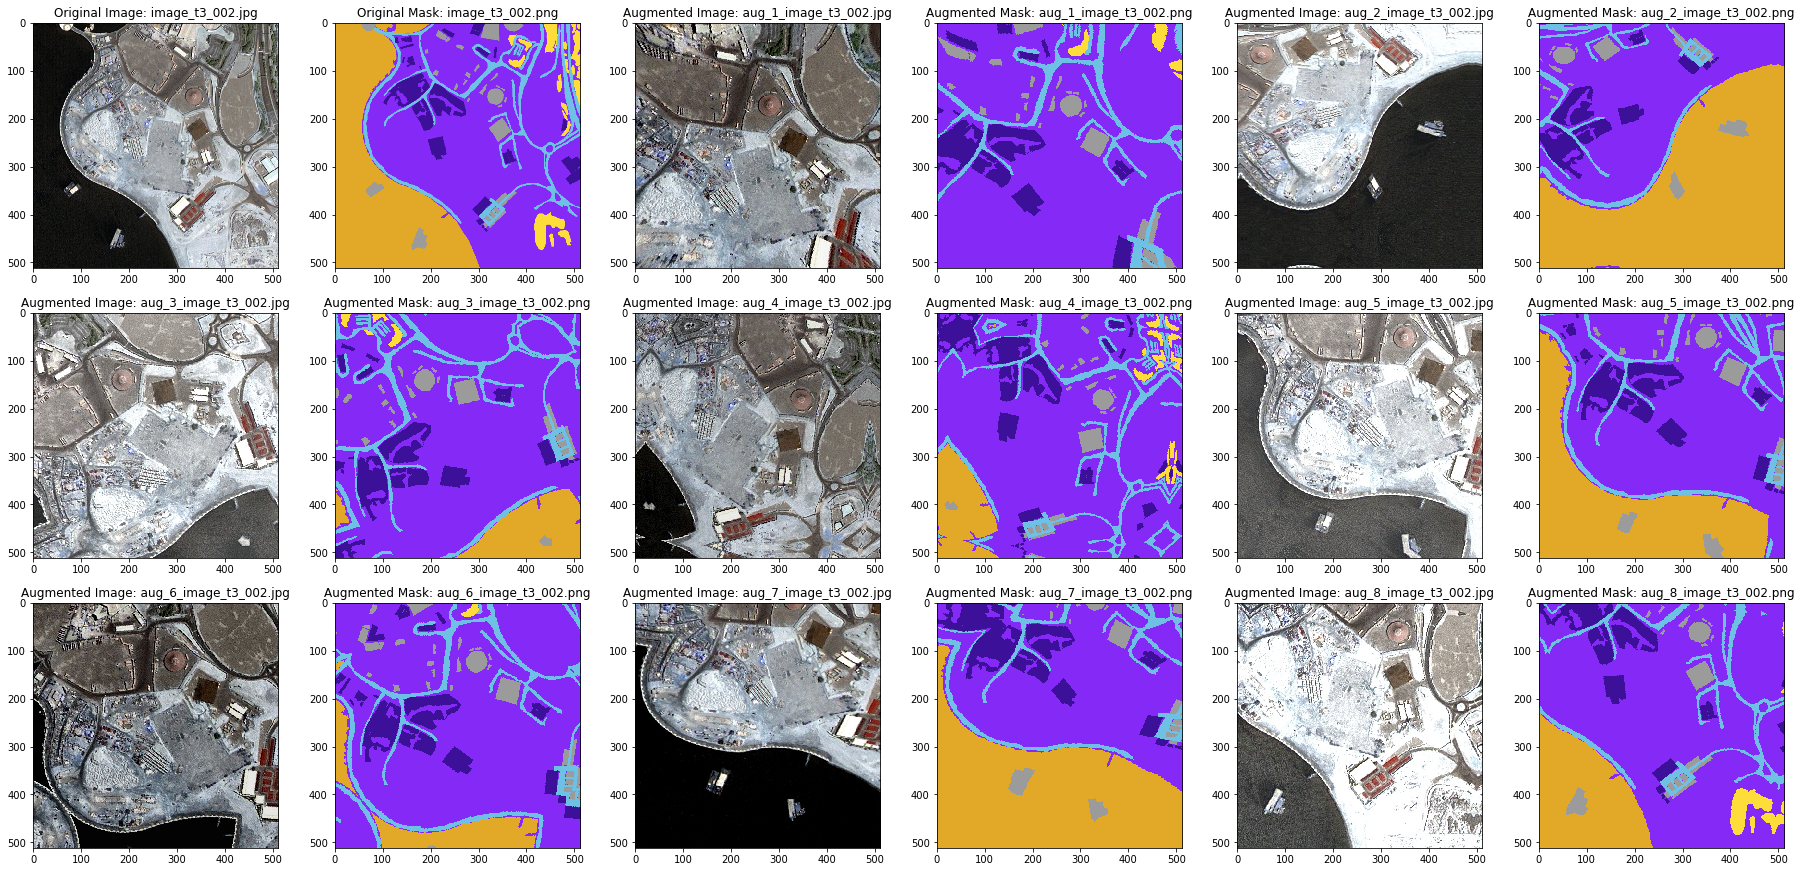

In [5]:
augmented_files = ['image_t1_002', 'image_t3_002']
dims = np.array([(512, 512), (512, 512), (800, 800), (800, 800), (800, 800)])

def show_augmented_images(files, original_images_dir, label_images_dir):
    dim_index = 0
    for file in files:
        count_img = 1
        count_msk = 1
        fig, axs = plt.subplots(3, 6, figsize=(25, 12), constrained_layout=True)
        for i in range(3):
            for j in range(6):
                if i == 0 and j == 0:
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(original_images_dir+'train/'+str(file)+'.jpg'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                    axs[i][j].set_title('Original Image: {}.jpg'.format(file), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                    axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                    axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                elif i == 0 and j == 1:
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(label_images_dir+'train/'+str(file)+'.png'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                    axs[i][j].set_title('Original Mask: {}.png'.format(file), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                    axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                    axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                else:
                    if j%2 == 0:
                        axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(original_images_dir+'train/aug_'+str(count_img)+'_'+str(file)+'.jpg'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                        axs[i][j].set_title('Augmented Image: aug_{}.jpg'.format(str(count_img)+'_'+str(file)), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                        axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                        axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                        axs[i][j].grid(False)
                        axs[i][j].axis(True)
                        count_img += 1
                    elif j%2 != 0:
                        axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(label_images_dir+'train/aug_'+str(count_msk)+'_'+str(file)+'.png'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                        axs[i][j].set_title('Augmented Mask: aug_{}.png'.format(str(count_msk)+'_'+str(file)), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                        axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                        axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                        axs[i][j].grid(False)
                        axs[i][j].axis(True)
                        count_msk += 1

        plt.savefig('aug_image_'+file, facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)
        dim_index += 1
        plt.show()

show_augmented_images(augmented_files, train_images, train_masks)

In [5]:
label_names= ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation',
              'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'unlabeled']
label_codes = []
r= [128,244,70,102,190,153,250,220,107,152,70,220,255,0,0,0,0,0,119,0]
g= [64,35,70,102,153,153,170,220,142,251,130,20,0,0,0,60,80,0,11,0]
b= [128,232,70,156,153,153,30,0,35,152,180,60,0,142,70,100,100,230,32,0]

for i in range(20):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(128, 64, 128),
  (244, 35, 232),
  (70, 70, 70),
  (102, 102, 156),
  (190, 153, 153),
  (153, 153, 153),
  (250, 170, 30),
  (220, 220, 0),
  (107, 142, 35),
  (152, 251, 152),
  (70, 130, 180),
  (220, 20, 60),
  (255, 0, 0),
  (0, 0, 142),
  (0, 0, 70),
  (0, 60, 100),
  (0, 80, 100),
  (0, 0, 230),
  (119, 11, 32),
  (0, 0, 0)],
 ['road',
  'sidewalk',
  'building',
  'wall',
  'fence',
  'pole',
  'traffic light',
  'traffic sign',
  'vegetation',
  'terrain',
  'sky',
  'person',
  'rider',
  'car',
  'truck',
  'bus',
  'train',
  'motorcycle',
  'bicycle',
  'unlabeled'])

In [6]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [7]:
id2code

{0: (128, 64, 128),
 1: (244, 35, 232),
 2: (70, 70, 70),
 3: (102, 102, 156),
 4: (190, 153, 153),
 5: (153, 153, 153),
 6: (250, 170, 30),
 7: (220, 220, 0),
 8: (107, 142, 35),
 9: (152, 251, 152),
 10: (70, 130, 180),
 11: (220, 20, 60),
 12: (255, 0, 0),
 13: (0, 0, 142),
 14: (0, 0, 70),
 15: (0, 60, 100),
 16: (0, 80, 100),
 17: (0, 0, 230),
 18: (119, 11, 32),
 19: (0, 0, 0)}

In [8]:
id2name

{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle',
 19: 'unlabeled'}

In [9]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [10]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [11]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (128, 128)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [13]:
batch_size = 16
num_train_samples = len(np.sort(os.listdir(train_images)))
num_val_samples = len(np.sort(os.listdir(val_images)))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  12.0
validation_steps:  3.0


In [42]:
"""
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model
    
"""    

SyntaxError: invalid syntax (<ipython-input-42-cbd8be458084>, line 20)

In [14]:
def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.5)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.5)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.5)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.5)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.5)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.5)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [15]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

#model = build_inception_resnetv2_unet(input_shape = (128, 128, 3))
model = multi_unet_model(n_classes=20, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

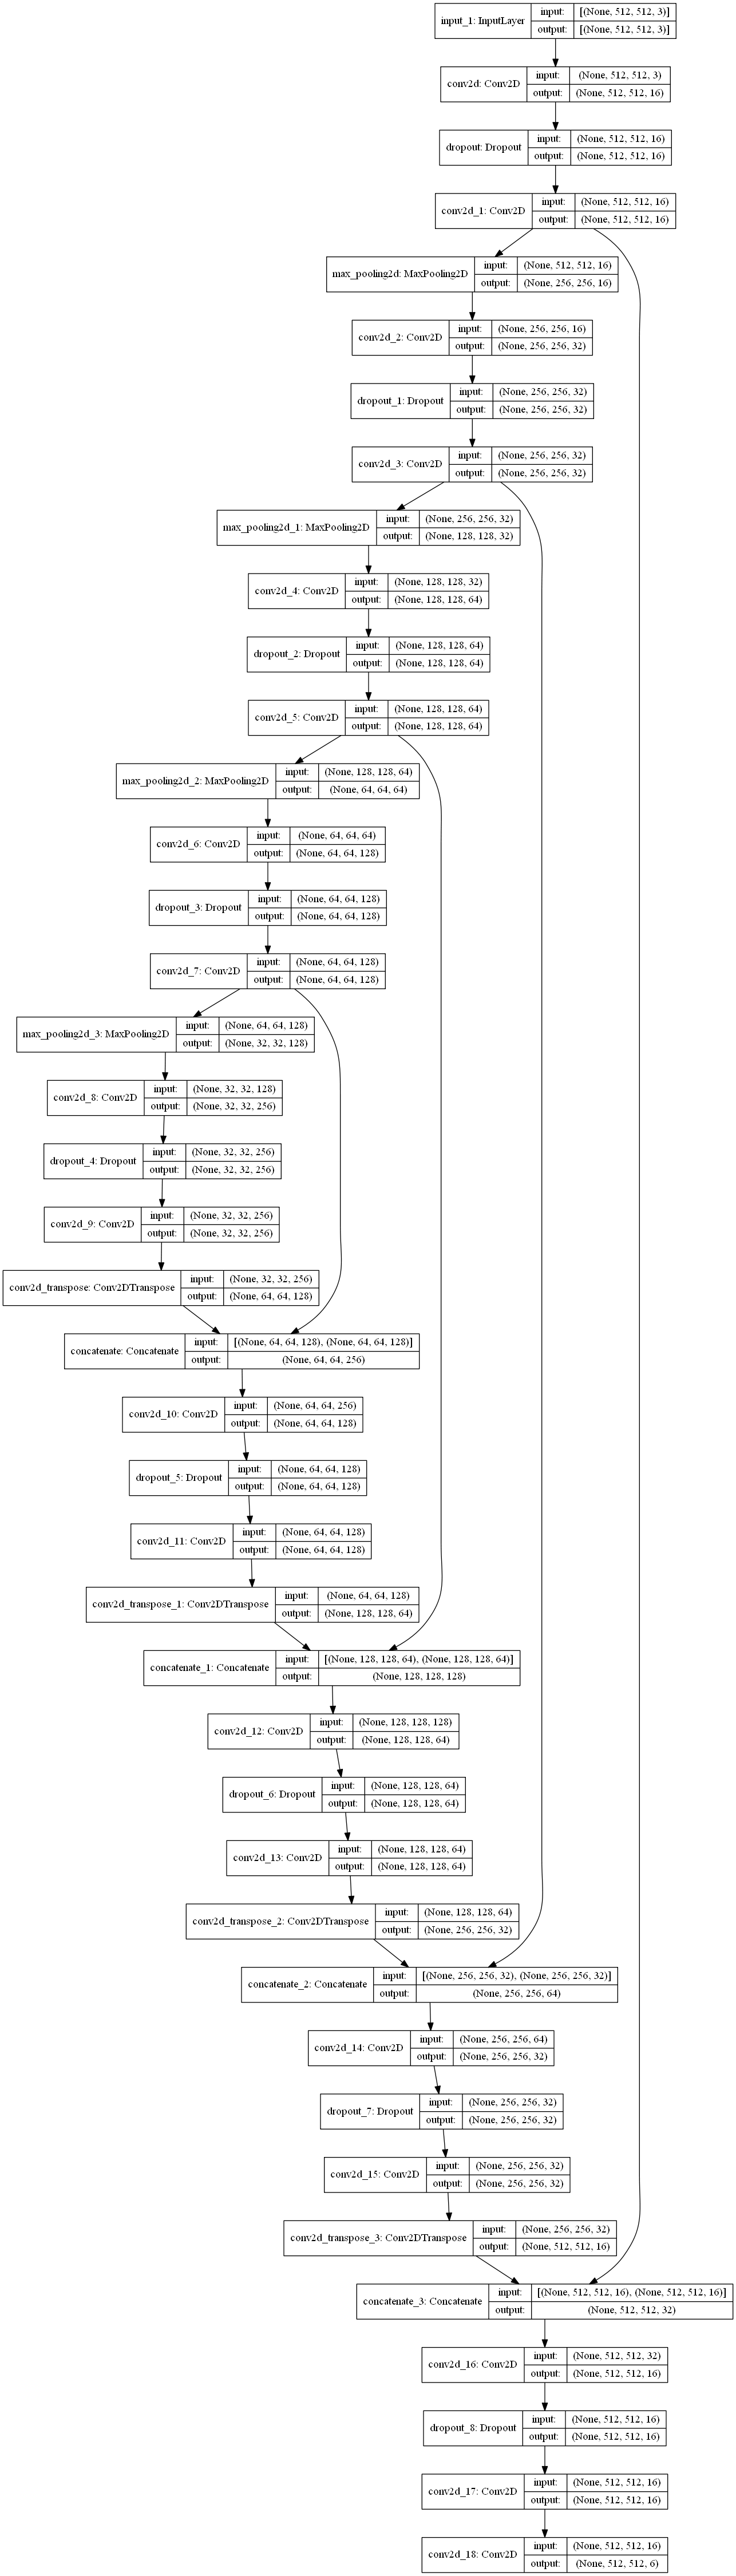

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [17]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [18]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = train_images, train_masks_dir = train_masks, target_size = (256, 256)), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (256, 256)), 
    validation_steps = validation_steps, 
    epochs = 60,
    callbacks=callbacks,
    use_multiprocessing=False,
    verbose=1
)
model.save('model.h5')

Found 504 images belonging to 1 classes.
Found 504 images belonging to 1 classes.
Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
32/32 [==============================] - ETA: 0s - loss: 5.0746 - dice_coef: 0.1162 - accuracy: 0.1124 Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
32/32 [==============================] - 472s 14s/step - loss: 5.0254 - dice_coef: 0.1165 - accuracy: 0.1124 - val_loss: 1.7759 - val_dice_coef: 0.1716 - val_accuracy: 0.0962

Epoch 00001: val_loss improved from inf to 1.77593, saving model to UNet.h5
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 9.623506263980886e-05.
32/32 [==============================] - 469s 15s/step - loss: 2.2050 - dice_coef: 0.1482 - accuracy: 0.1183 - val_loss: 1.7134 - val_dice_coef: 0.1818 - val_accuracy: 0.1925

Epoch 00002: val_loss improved from 1.77593 to 1.71344, saving model to UNet.h5
Epoch 3/60

Epoch 00003: LearningRateScheduler red

KeyboardInterrupt: 

In [ ]:
df_result = pd.DataFrame(history.history)
df_result

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

In [ ]:
testing_gen = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512))

In [ ]:
!mkdir predictions

In [ ]:
count = 0
for i in range(2):
    batch_img,batch_mask = next(testing_gen)
    pred_all= model.predict(batch_img)
    np.shape(pred_all)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.grid(False)

        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.imshow(onehot_to_rgb(batch_mask[j],id2code))
        ax2.grid(False)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.imshow(onehot_to_rgb(pred_all[j],id2code))
        ax3.grid(False)

        plt.savefig('./predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
        plt.show()

In [24]:
"""  this is for predictions  """
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = load_model("models/60_256_5/model.h5", custom_objects={'dice_coef':dice_coef})

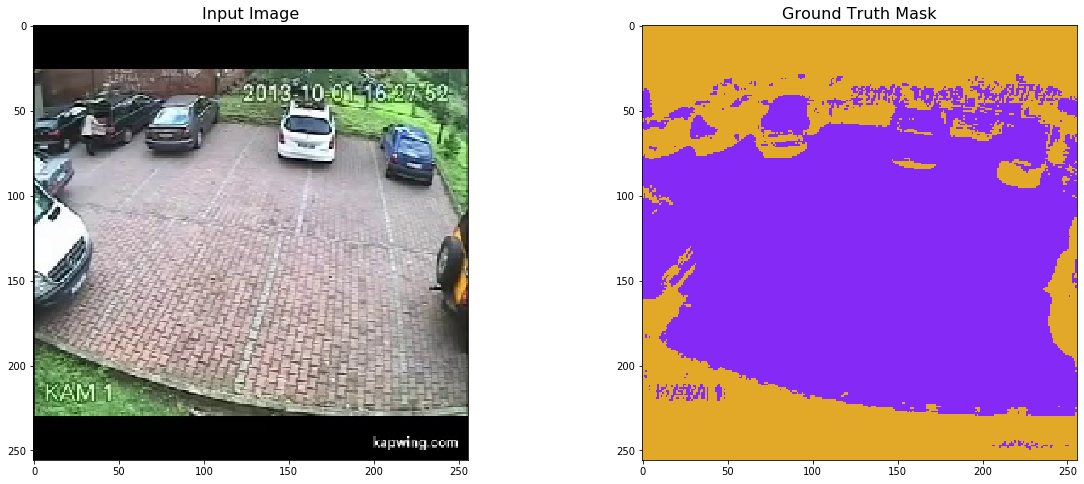

In [26]:
img_path = 'check/6.jpg'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)
datagen = ImageDataGenerator(rescale=1./255)

for batch in datagen.flow(img_array_expanded_dims, batch_size=1):
    pred = model.predict(batch)
    break
    
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(batch[0])
ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax1.grid(False)

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax2.imshow(onehot_to_rgb(pred[0],id2code))
ax2.grid(False)

plt.show()   